# Blob Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

## Read and display test image of cells under a microscope

In [2]:
img = cv2.imread("cell.png", cv2.IMREAD_GRAYSCALE)

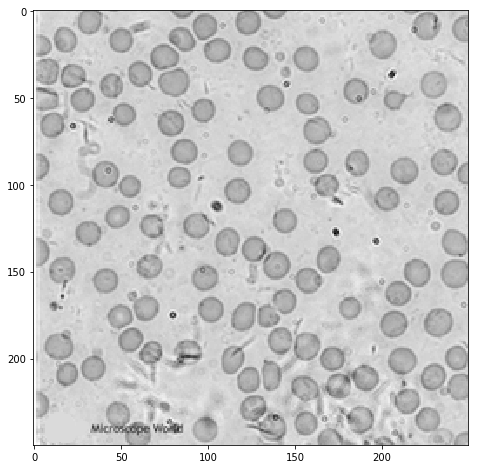

In [3]:
plt.figure(figsize=(10,8))
plt.imshow(img,cmap='gray')
# plt.savefig('grayscale.png',dpi=300,bbox_inches='tight')
plt.show()

## Histogram of grayscale image

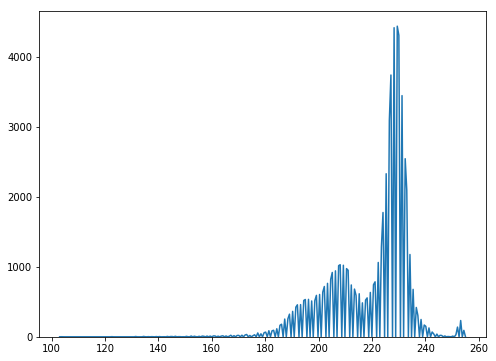

In [4]:
vals,bins = np.histogram(img.flatten(),bins=256)

plt.figure(figsize=(8,6))
plt.plot(bins,[0]+vals.tolist())
plt.ylim(0,)
# plt.savefig('hist.png',dpi=300,bbox_inches='tight')
plt.show()

## Binarize image using thresholding from its histogram of values

In [7]:
binary = np.array(img>220)*255
binary2 = (np.array(img>220)-1)*(-255)
binary = binary.astype('uint8')
binary2 = binary2.astype('uint8')

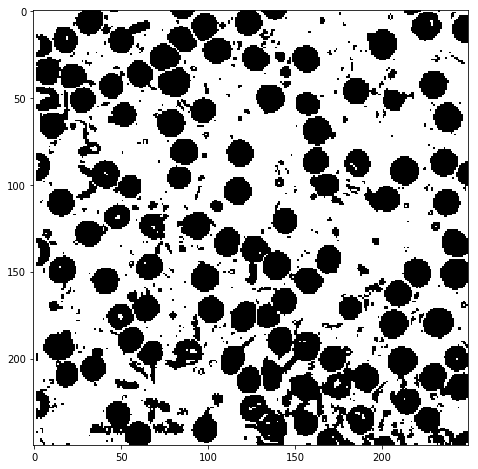

In [8]:
plt.figure(figsize=(10,8))
plt.imshow(binary,cmap='gray')
# plt.savefig('bin1.png',dpi=300,bbox_inches='tight')
plt.show()

## Non-parametric Segmentation code from previous activity

In [9]:
def RGI(image):
    R = np.float_(image[:,:,0])
    G = np.float_(image[:,:,1])
    B = np.float_(image[:,:,2])
    
    I = np.float_(R+G+B)
    I[I==0] = 100000

    r = R/I
    g = G/I
    b = B/I
    
    return np.float_(r),np.float_(g),np.float_(b)

In [10]:
def non_para(bins):
    r_int = np.round(p_r*(bins-1))
    g_int = np.round(p_g*(bins-1))
    
    R_int = np.round(im_r*(bins-1)+1)
    G_int = np.round(im_g*(bins-1)+1)
    
    return r_int,g_int,R_int,G_int

In [11]:
def segmenting(img,limit):
    x,y = np.where(img<limit)
    segment = np.copy(whole)
    segment[x,y,:] = [255,255,255] 
    
    plt.figure(figsize=(18,16))
    plt.subplot(131)
    plt.imshow(img,cmap='gray'),plt.xticks([]),plt.yticks([])

    plt.subplot(132)
    plt.imshow(whole),plt.xticks([]),plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(segment),plt.xticks([]),plt.yticks([])
    plt.savefig('nonpara.png',dpi=300,bbox_inches='tight')
    plt.show()

### Perform Nonparametric Segmentation on binarized image

In [12]:
whole = plt.imread('cell.png')
patch = plt.imread('cell_patch.png')
im_r,im_g,im_b = RGI(whole)
p_r,p_g,p_b = RGI(patch)

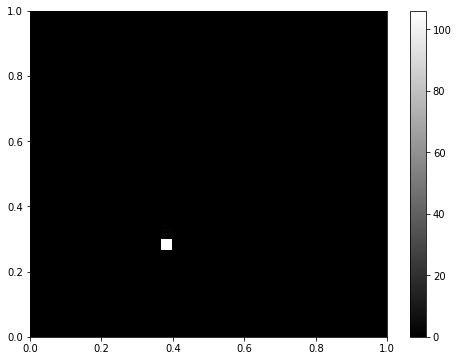

In [13]:
bins = 30
r_int,g_int,R_int,G_int = non_para(bins)

plt.figure(figsize=(8,6))
h = plt.hist2d(r_int.flatten()/bins,g_int.flatten()/bins,bins=bins,range=[[0,1],[0,1]],cmap='gray')[0]
plt.colorbar()
# plt.savefig('ura_hist.png',dpi=300,bbox_inches='tight')
plt.show()

### Histogram backprojection to "segment" cells from test image

In [14]:
new_img = np.zeros((whole.shape[0],whole.shape[1]))

for i in range(whole.shape[0]-1):
    for j in range(whole.shape[1]-1):
        new_img[i][j] += h[np.int(R_int[i][j])-1,np.int(G_int[i][j])-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


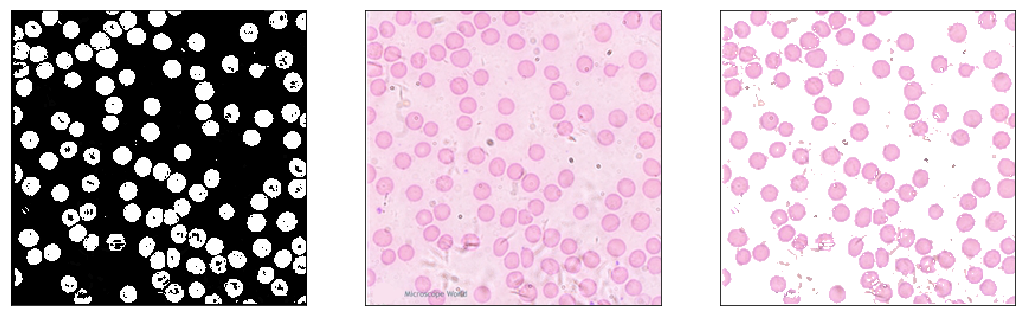

In [15]:
new_img = np.round(255*new_img/np.amax(new_img)).astype('uint8')
segmenting(new_img,1)

## Perform Erosion and Dilation (Morphological Operations) to clean segmented blobs (cells)

In [16]:
cleaning = np.copy(binary2)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

opening = cv2.morphologyEx(cleaning, cv2.MORPH_OPEN, kernel, iterations=3)
# closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
# closing = cv2.morphologyEx(cleaning, cv2.MORPH_CLOSE, kernel, iterations=3)
# opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=1)

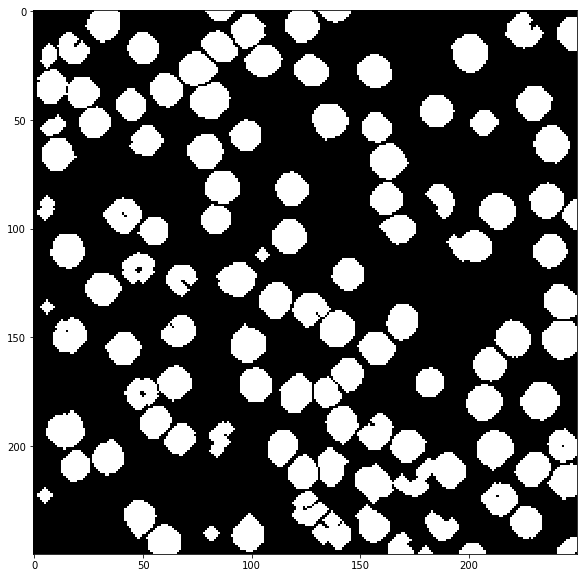

In [17]:
plt.figure(figsize=(14,10))

# plt.subplot(121)
# plt.imshow(cleaning,cmap='gray')#,plt.xticks([]),plt.yticks([])
# plt.subplot(122)
plt.imshow(opening,cmap='gray')#,plt.xticks([]),plt.yticks([])
# plt.savefig('bin2_opening.png',dpi=300,bbox_inches='tight')
plt.show()

## Setting up optimal parameters for blob detector 
#### Obtained through trial and error to get best-looking results

In [18]:
params = cv2.SimpleBlobDetector_Params()

params.filterByColor = True
params.blobColor = 255

# Filter by Area
params.filterByArea = True
params.minArea = 50
params.maxArea = 250

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.4

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.0001

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

## Find keypoints using detector

In [19]:
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(opening)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

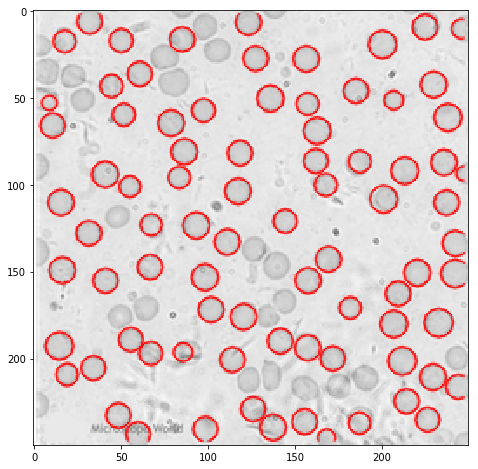

In [21]:
plt.figure(figsize=(10,8))

plt.imshow(im_with_keypoints)
# plt.savefig('nonpara_blobs.png',dpi=300,bbox_inches='tight')
plt.show()

## Getting diameter of blobs

In [22]:
diameters = []

for k in keypoints:
    diameters.append(k.size)
    
diameters = np.array(diameters)

## Getting mean area of blobs

In [23]:
areas = ((diameters/2)**2)*np.pi
mean_area = np.mean(areas)
std_area = np.std(areas)

## Getting mean perimeter of blobs

In [24]:
perimeter = diameters*np.pi
mean_perimeter = np.mean(perimeter)
std_perimeter = np.std(perimeter)

## Getting mean diameter of blobs

In [25]:
mean_dia = np.mean(diameters)
std_dia = np.std(diameters)